In [1]:
from metabolinks import read_aligned_spectra, read_spectra_from_xcel, AlignedSpectra
from metabolinks.similarity import mz_similarity
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats
import scaling as sca
import multianalysis as ma

import numpy as np
import pandas as pd
import re

In [2]:
%matplotlib inline
from matplotlib import pyplot as pl


# testing files


In [3]:
#Function to remove features that appear in less the minsample % of the samples
def remove_feat(Spectra, minsample=0):
    Imputated = Spectra
    df = Imputated
    if minsample != 0:
        NumValues = Imputated.iloc[:,3:].notnull()
        a = 0
        print(Spectra)
        for i in range(0, len(NumValues)): 
            if sum(NumValues.iloc[i, :]) < minsample*15:
                # Taking away features that appear in less of minsample% of samples.
                df = df.drop([df.iloc[a].name])
            else:
                a = a + 1

    return df

In [4]:
by1_df_T = pd.read_excel('ThesisSupportExcel.xlsx', sheet_name='MS').set_index('Bucket label')
by1_df_T = by1_df_T.replace({0:np.nan})
by1_df_T = remove_feat(by1_df_T, 2/15)
by1_df_T.info()
by1_df_T
by1_df = by1_df_T.iloc[:,:4]
by1_df

                           m/z                   Name          Formula  \
Bucket label                                                             
307,0838178877 Da    308.09110            Glutathione      C10H17N3O6S   
555,2692975341 Da    556.27657           Enkephalin L       C28H37N5O7   
624,0873082632 Da    625.09457                    NaN   C14H28N10O10S4   
493,3168156897 Da    494.32410        PC_16:1_9Z_0:0_       C24H48NO7P   
257,1028750516 Da    258.11016  Glycerophosphocholine        C8H20NO6P   
...                        ...                    ...              ...   
2029,1188620710 Da  2030.12614                    NaN              NaN   
532,8123880500 Da    533.81966                    NaN      C9H4N5O8PS6   
1069,9969559833 Da  1071.00423                    NaN   C37H18N16O16S4   
1343,9006014319 Da  1344.90788                    NaN   C57H32N6O12S11   
1941,3559575318 Da  1942.36323                    NaN  C39H66N47O39P3S   

                      BY0_000001    B

,m/z,Name,Formula,BY0_000001
Bucket label,,,,
"307,0838178877 Da",308.09110,Glutathione,C10H17N3O6S,1.482951e+09
"555,2692975341 Da",556.27657,Enkephalin L,C28H37N5O7,4.219694e+08
"624,0873082632 Da",625.09457,NaN,C14H28N10O10S4,4.933358e+08
"493,3168156897 Da",494.32410,PC_16:1_9Z_0:0_,C24H48NO7P,4.026932e+08
"257,1028750516 Da",258.11016,Glycerophosphocholine,C8H20NO6P,2.056732e+08
...,...,...,...,...
"892,5313342202 Da",893.53861,NaN,C48H72N6O10,NaN
"847,0028787316 Da",848.01016,NaN,C22H6N23O12PS,NaN
"535,6351204857 Da",536.64240,NaN,NaN,NaN


In [5]:
s1 = pd.DataFrame({'Bucket label': ['A0 Da', 'A1 Da', 'A2 Da', 'A3 Da'],
                    'Name': ['B0', np.nan, 'B2', 'B3'],
                    'Formula': ['C0', 'C1', 'C2', 'C3']},
                    index=[0, 1, 2, 3]).set_index('Bucket label')
s2 = pd.DataFrame({'Bucket label': ['A0 Da', 'A1 Da', 'A2 Da', 'A4 Da'],
                    'Name': ['B0', np.nan, 'B2', 'B4'],
                    'Formula': ['C0', 'C1', 'C2', 'C4']},
                    index=[0, 1, 2, 3]).set_index('Bucket label')

s3 = pd.DataFrame({'Bucket label': ['A0 Da', 'A1 Da', 'A4 Da', 'A7 Da'],
                    'Name': ['B0', np.nan, 'B4', 'B7'],
                    'Formula': ['C0', 'C1', 'C4', 'C7']},
                    index=[0, 1, 2, 3]).set_index('Bucket label')
print(s1, end='\n\n')
print(s2, end='\n\n')
print(s3)

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A3 Da          B3      C3

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A4 Da          B4      C4

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A4 Da          B4      C4
A7 Da          B7      C7



# Data filtering and cleaning

Functions to restrict a dataframe to just a few columns and to filter features with zero intensity.


In [6]:
def remove_zero_intensity(data, intensity_col=''):
    non_zero = data[intensity_col] > 1e5
    return data[non_zero]

def simplify_data(data, keep_cols=('Name', 'Formula')):
    return data[list(keep_cols)]

def clean_empty_formulae(data, formula_col='Formula'):
    where_formula = data[formula_col].notna()
    return data[where_formula]

# USE LIKE THIS
by1_df_nz = remove_zero_intensity(by1_df, intensity_col='BY0_000001')
by1_df_nz = simplify_data(by1_df_nz)


by1_df_clean = clean_empty_formulae(by1_df_nz)

# now the size of the Formula column should be equal to the number of entries (check the info)
by1_df_clean.info()
by1_df_clean

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 307,0838178877 Da to 993,3559026450 Da
Data columns (total 2 columns):
Name       164 non-null object
Formula    608 non-null object
dtypes: object(2)
memory usage: 14.2+ KB


,Name,Formula
Bucket label,,
"307,0838178877 Da",Glutathione,C10H17N3O6S
"555,2692975341 Da",Enkephalin L,C28H37N5O7
"624,0873082632 Da",NaN,C14H28N10O10S4
"493,3168156897 Da",PC_16:1_9Z_0:0_,C24H48NO7P
"257,1028750516 Da",Glycerophosphocholine,C8H20NO6P
...,...,...
"831,6037485019 Da",NaN,C35H82N11O9P
"567,4167007326 Da",NaN,C31H58N3O4P
"493,3225194981 Da",NaN,C20H51N3O6S2


# Merge replicas with at least two ocorrences.

### Function to perform the merge of replicas keeping features with a minimum of ocorrences

In [7]:
def merge_replicas(samples, minimum=2):
    """Return merged replicas, keeping features with a minimum of ocorrences."""
    # concat all samples
    concatenation = pd.concat(samples)
    # print(concatenation)
    
    # find indexes that occur more than a minimum times
    reps = concatenation.index.value_counts()
    reps = reps[reps >= minimum]
    # print(reps)
    
    # keep only those
    more_than_minimum = concatenation.index.isin(reps.index)
    filtered = concatenation[more_than_minimum]
    # print('--------')
    # print(filtered)
    
    # remove duplicates. NOTE: duplicates hold exactely the same data.
    merged = filtered.loc[~filtered.index.duplicated(keep='first')]
    return merged

print('--- datasets to merge')
print(s1, end='\n\n')
print(s2, end='\n\n')
print(s3)
# USE LIKE THIS
print('\n--- merged with a minimum of 2')
merged = merge_replicas([s1, s2, s3])
merged

--- datasets to merge
             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A3 Da          B3      C3

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A4 Da          B4      C4

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A4 Da          B4      C4
A7 Da          B7      C7

--- merged with a minimum of 2


,Name,Formula
Bucket label,,
A0 Da,B0,C0
A1 Da,NaN,C1
A2 Da,B2,C2
A4 Da,B4,C4


# Common and exclusive features

### Functions to compute common and exclusive features from a list of samples

In [8]:
def common(samples):
    """Given a list of n samples, compute common features (intersection).
    
       Returns a DataFrame with common features"""
    
    join = pd.concat(samples, axis=1, join='inner', keys=range(len(samples)))
    return join[0]

def exclusive(samples):
    """Given a list of samples, compute exclusive features for each sample.
    
       Returns a a list of DataFrames with exclusive features for each corresponding sample in input"""
    
    # concat all samples
    concatenation = pd.concat(samples)
    
    # find indexes that occur only once
    reps = concatenation.index.value_counts()
    exclusive_feature_counts = reps[reps == 1]
    
    # keep only those in each sample

    exclusive = [s[s.index.isin(exclusive_feature_counts.index)] for s in samples]
    return exclusive
    
    
# USE LIKE THIS
print('--- example data sets')
print(s1, end='\n\n')
print(s2, end='\n\n')
print(s3)

samples = [s1, s2, s3]

print('\n---------- Common to all')
common_to_all = common(samples)
print(common_to_all)

print('\n---------- Common features for every combination of two samples')
pair_intersections = {}
n = len(samples)
for i in range(n-1):
    for j in range(i+1, n):
        pair_intersections[(i,j)] = common([samples[i], samples[j]])

for (i, j) in pair_intersections:
    print(f'\n--- common between s{i} and s{j}')
    print(pair_intersections[(i,j)])


print('\n----------- Exclusive features')
exclusive_features = exclusive(samples)

for i, e in enumerate(exclusive_features):
    print('\n---- Exclusive to sample', i+1)
    print(e)

--- example data sets
             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A3 Da          B3      C3

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A4 Da          B4      C4

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A4 Da          B4      C4
A7 Da          B7      C7

---------- Common to all
             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1

---------- Common features for every combination of two samples

--- common between s0 and s1
             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2

--- common between s0 and s2
             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1

--- common between

# Split elements

In [9]:
elem_pattern = r'[A-Z][a-z]?\d*'
elem_groups = r'([A-Z][a-z]?)(\d*)'

def element_composition(formula, elements=None):
    """Returns dictionary of element composition.
    
    Can restrict to given list of elements."""
    elem_pattern = r'[A-Z][a-z]?\d*'
    elem_groups = r'([A-Z][a-z]?)(\d*)'
    composition = {}
    for elemp in re.findall(elem_pattern, formula):
        match = re.match(elem_groups, elemp)
        n = match.group(2)
        number = int(n) if n != '' else 1
        composition[match.group(1)] = number
    
    if elements is None:
        return composition
    
    return {e : composition.get(e, 0) for e in elements}

for test in 'C11H24NO7P', 'C13H19ClN2O2', 'C12H21O11R': # works with "R" and "X" elements.
     print(test, '->', element_composition(test))

C11H24NO7P -> {'C': 11, 'H': 24, 'N': 1, 'O': 7, 'P': 1}
C13H19ClN2O2 -> {'C': 13, 'H': 19, 'Cl': 1, 'N': 2, 'O': 2}
C12H21O11R -> {'C': 12, 'H': 21, 'O': 11, 'R': 1}


Use example

In [10]:
by1_df_nz = remove_zero_intensity(by1_df, intensity_col='BY0_000001')
by1_df_nz = simplify_data(by1_df_nz)

by1_clean = clean_empty_formulae(by1_df_nz)
#by1_clean = by1_clean.loc[~by1_clean['Formula'].duplicated(keep='first')]
# now the size of the Formula column should be equal to the number of entries (check the info)
by1_clean.info()
by1_clean

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 307,0838178877 Da to 993,3559026450 Da
Data columns (total 2 columns):
Name       164 non-null object
Formula    608 non-null object
dtypes: object(2)
memory usage: 14.2+ KB


,Name,Formula
Bucket label,,
"307,0838178877 Da",Glutathione,C10H17N3O6S
"555,2692975341 Da",Enkephalin L,C28H37N5O7
"624,0873082632 Da",NaN,C14H28N10O10S4
"493,3168156897 Da",PC_16:1_9Z_0:0_,C24H48NO7P
"257,1028750516 Da",Glycerophosphocholine,C8H20NO6P
...,...,...
"831,6037485019 Da",NaN,C35H82N11O9P
"567,4167007326 Da",NaN,C31H58N3O4P
"493,3225194981 Da",NaN,C20H51N3O6S2


In [11]:
def create_elememt_counts(data, formula_col='Formula', compute_ratios=True, 
                          series=('CHO', 'CHOS', 'CHON', 'CHNS', 'CHONS', 'CHOP', 'CHONP','CHONSP')):
    """Create DataFrame from element counts and concat to original DataFrame.
    
       Optionally, the ratios of H/C and O/C and element composition series are also computed"""

    # safe guard: remove empty formulae
    formulae = data[formula_col]
    formulae = formulae[formulae.notnull()]
    
    # count elements
    ecounts_list = [element_composition(f) for f in formulae.values]
    ecounts = pd.DataFrame(ecounts_list, index=formulae.index).fillna(0).astype(int)
    
    # concat to data
    result = pd.concat([data, ecounts], axis=1)
    
    # compute ratios for VK plots
    if compute_ratios:
        result['H/C'] = result['H'] / result['C']
        result['O/C'] = result['O'] / result['C']

    # compute series from compositions
    
    sorted_series = [''.join(sorted(list(s))) for s in series]
    result_series = []
   
    for composition in ecounts_list:
        nonzero = ''.join(sorted([k for k, c in composition.items() if c > 0]))
        
        if nonzero in sorted_series:
            result_series.append(series[sorted_series.index(nonzero)])
        else:
            result_series.append('other')

    result['Series'] = pd.Series(result_series, index=result.index)

    return result

# USE LIKE THIS

by1_elems = create_elememt_counts(by1_clean)
by1_elems#[by1_elems['H/C']<0.5]

,Name,Formula,C,H,N,O,S,P,H/C,O/C,Series
Bucket label,,,,,,,,,,,
"307,0838178877 Da",Glutathione,C10H17N3O6S,10,17,3,6,1,0,1.700000,0.600000,CHONS
"555,2692975341 Da",Enkephalin L,C28H37N5O7,28,37,5,7,0,0,1.321429,0.250000,CHON
"624,0873082632 Da",NaN,C14H28N10O10S4,14,28,10,10,4,0,2.000000,0.714286,CHONS
"493,3168156897 Da",PC_16:1_9Z_0:0_,C24H48NO7P,24,48,1,7,0,1,2.000000,0.291667,CHONP
"257,1028750516 Da",Glycerophosphocholine,C8H20NO6P,8,20,1,6,0,1,2.500000,0.750000,CHONP
...,...,...,...,...,...,...,...,...,...,...,...
"831,6037485019 Da",NaN,C35H82N11O9P,35,82,11,9,0,1,2.342857,0.257143,CHONP
"567,4167007326 Da",NaN,C31H58N3O4P,31,58,3,4,0,1,1.870968,0.129032,CHONP
"493,3225194981 Da",NaN,C20H51N3O6S2,20,51,3,6,2,0,2.550000,0.300000,CHONS


# VK plot

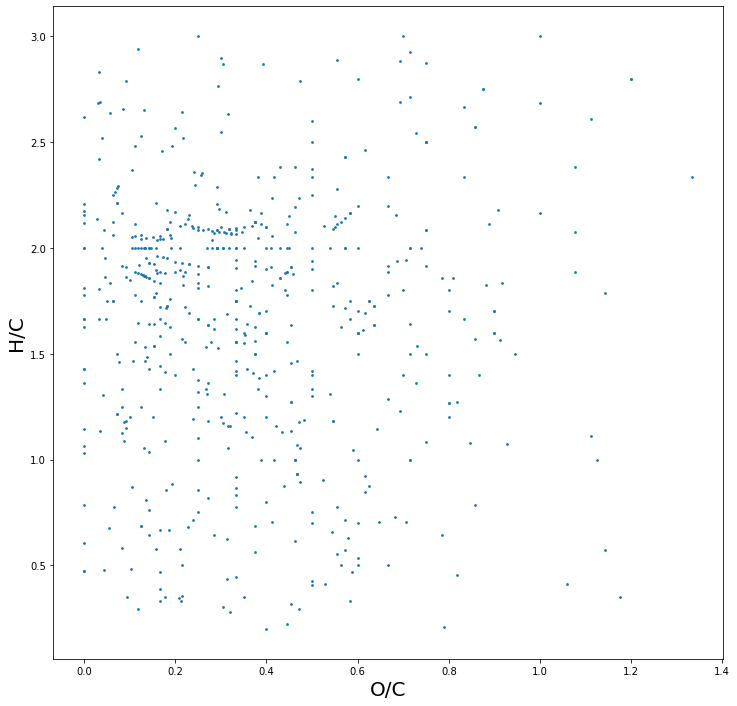

In [12]:
def VK_plot(data):
    y = data['H/C']
    x = data['O/C']
    pl.subplots(1,1, figsize=(12,12))
    pl.scatter(x, y, s=3)
    pl.xlabel('O/C', fontsize=20)
    pl.ylabel('H/C', fontsize=20)

VK_plot(by1_elems)
# to save the picture to a svg file

pl.savefig('VK.svg')

## Composition series

CHO        87
CHOS       37
CHON      143
CHNS       13
CHONS     150
CHOP       24
CHONP      76
CHONSP     58
other      20
Name: Series, dtype: int64


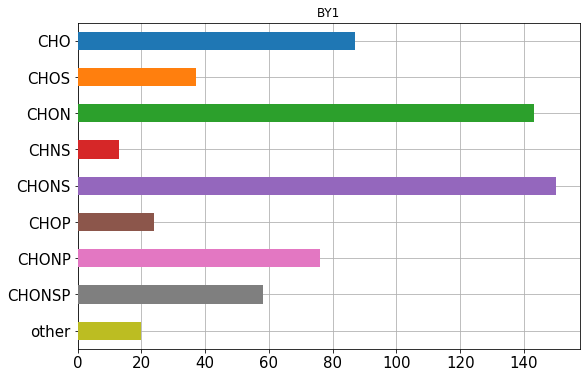

In [13]:
from matplotlib import cm

def plot_composition_series(data, title='',
                            series_order=('CHO', 'CHOS', 'CHON', 'CHNS', 'CHONS', 'CHOP', 'CHONP','CHONSP', 'other')):
    counts = data['Series'].value_counts().reindex(series_order)
    print(counts)
    colors = cm.get_cmap('tab10', 10).colors
    counts.plot(kind = 'barh', figsize=(9,6), color=colors, fontsize=15, title=title, zorder=3)
    pl.gca().invert_yaxis()
    pl.grid(zorder=0)

plot_composition_series(by1_elems, title='BY1')

# to save the picture to a svg file

pl.savefig('series_by1.svg')

### Setting up all results to use after

In [14]:
def pipeline (Datas):
    Datas_nz = remove_zero_intensity(Datas, intensity_col=Datas.columns[-1])
    Datas_nz = simplify_data(Datas_nz)
    Datas_clean = clean_empty_formulae(Datas_nz)
    Datas_clean = Datas_clean.loc[~Datas_clean['Formula'].duplicated(keep='first')]
    Datas_elems = create_elememt_counts(Datas_clean)
    return Datas_elems

In [15]:
Results = {}
Classes = {}
for i in range(15):
    Data = by1_df_T.iloc[:,:3].join(by1_df_T.iloc[:,3+i])
    #print(Data)
    Elems = pipeline(Data)
    Results[Data.columns[-1]] = Elems[['H/C', 'O/C']]
    Classes[Data.columns[-1]] = Elems['Series'].value_counts()

In [16]:
BY1 = Results['BY0_000001']
BY2 = Results['BY0_000002']
#print(BY1)
#BY1 = BY1.loc[~BY1['H/C'].duplicated(keep='first')]
#for i in range(len(BY1)):
#    for j in range(len(BY1)):
#        if i != j:
#            if BY1.iloc[i,0] == BY1.iloc[j,0]:
#                things
BY1["period"] = BY1["H/C"].astype(str) + BY1["O/C"].astype(str)
BY1 = BY1.loc[~BY1['period'].duplicated(keep='first')]
BY2["period"] = BY2["H/C"].astype(str) + BY2["O/C"].astype(str)
BY2 = BY2.loc[~BY2['period'].duplicated(keep='first')]
#print(len(BY1))

In [17]:
BY2 = Results['BY0_000002']
BY2_p = np.unique(BY2[['H/C','O/C']].to_numpy(), axis = 0)

BY1 = Results['BY0_000001']
BY1_p = np.unique(BY1[['H/C','O/C']].to_numpy(), axis = 0)
nrows, ncols = BY1_p.shape
dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [BY1_p.dtype]}

a = np.intersect1d(BY1_p.view(dtype), BY2_p.view(dtype))
b = np.union1d(BY1_p.view(dtype), BY2_p.view(dtype))
#t_stop = time()
#print(BY1_p.view(dtype),BY2_p.view(dtype))
#print(dtype)

### DataFrame with number of times each set of H/C and O/C appears in a sample

In [18]:
BY1 = Results['BY0_000001']
BY1_p = np.unique(BY1[['H/C','O/C']].to_numpy(), axis = 0)
nrows, ncols = BY1_p.shape
dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [BY1_p.dtype]}

Results_f = {}
jdists = pd.DataFrame(index=Results.keys(), columns = Results.keys())
for i in Results:
    #Limpar replciate peaks
    Results_f[i] = np.unique(Results[i][['H/C','O/C']].to_numpy(), axis = 0, return_counts = True)
c = Results_f['BY0_000001'][0].view(dtype)
for i in Results_f:
    c = np.union1d(c, Results_f[i][0].view(dtype))
    for j in Results_f:
        a = np.intersect1d(Results_f[i][0].view(dtype), Results_f[j][0].view(dtype))  
        b = np.union1d(Results_f[i][0].view(dtype), Results_f[j][0].view(dtype))
        jdists.loc[i,j] = 1 - len(a)/len(b)

In [19]:
ddd = np.unique(Results[i][['H/C','O/C']].to_numpy(), axis = 0, return_counts = True)
ddd[0][84]

array([1.        , 0.46153846])

In [20]:
NewD = pd.DataFrame(np.zeros((len(c),15)),index = c, columns = Results.keys())
#Results_f['BY0_000001'][0] in NewD.index
#NewD.loc[tuple(Results_f['BY0_000001'][0])]
#if tuple(Results_f['BY0_000001'][0]) in NewD.index:
for i in Results_f:
    for j in range(len(Results_f[i][0])):
        NewD.loc[[tuple(Results_f[i][0][j])],i] = Results_f[i][1][j]
NewD

,BY0_000001,BY0_000002,BY0_000003,GRE3_000001,GRE3_000002,GRE3_000003,ENO1_000001,ENO1_000002,ENO1_000003,dGLO1_000001,dGLO1_000002,dGLO1_000003,GLO2_000001,GLO2_000002,GLO2_000003
"(0.2, 0.17142857142857143)",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"(0.2, 0.35)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.2, 0.4)",1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
"(0.2, 0.55)",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"(0.20689655172413793, 0.034482758620689655)",0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3.0833333333333335, 0.2916666666666667)",0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3.0869565217391304, 0.17391304347826086)",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"(3.090909090909091, 0.09090909090909091)",0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3.090909090909091, 0.18181818181818182)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


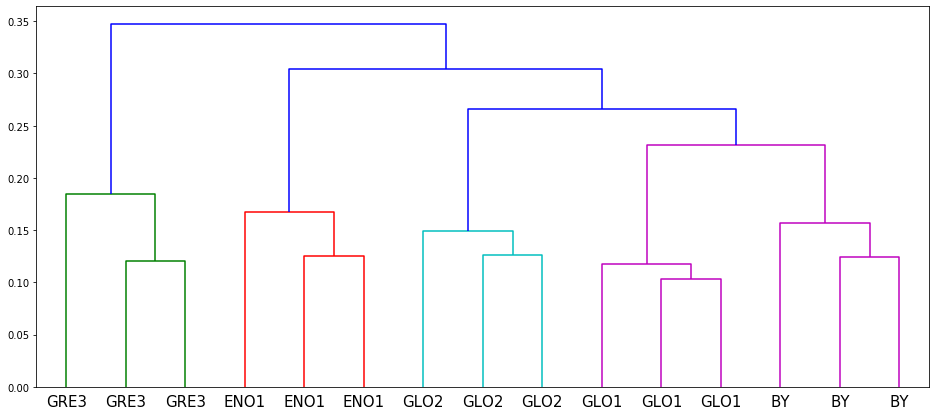

In [21]:
labels = ["BY","BY","BY","GRE3","GRE3","GRE3","ENO1","ENO1","ENO1","GLO1","GLO1","GLO1","GLO2","GLO2","GLO2"]
Zdice_neg = hier.linkage(NewD.T, metric = 'yule', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=labels,
                     leaf_font_size=15,
                     above_threshold_color='b')

### DataFrame with 1's and 0's

In [22]:
BY1 = Results['BY0_000001']
BY1_p = np.unique(BY1[['H/C','O/C']].to_numpy(), axis = 0)
nrows, ncols = BY1_p.shape
dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [BY1_p.dtype]}

Results_f = {}
jdists = pd.DataFrame(index=Results.keys(), columns = Results.keys())
for i in Results:
    #Limpar replciate peaks
    Results_f[i] = np.unique(Results[i][['H/C','O/C']].to_numpy(), axis = 0)
c = Results_f['BY0_000001'].view(dtype)
for i in Results_f:
    c = np.union1d(c, Results_f[i].view(dtype))
    for j in Results_f:
        a = np.intersect1d(Results_f[i].view(dtype), Results_f[j].view(dtype))  
        b = np.union1d(Results_f[i].view(dtype), Results_f[j].view(dtype))
        jdists.loc[i,j] = 1 - len(a)/len(b)

In [23]:
#ddd = np.unique(Results[i][['H/C','O/C']].to_numpy(), axis = 0, return_counts = True)

In [24]:
NewD = pd.DataFrame(np.zeros((len(c),15)),index = c, columns = Results.keys())
#Results_f['BY0_000001'][0] in NewD.index
#NewD.loc[tuple(Results_f['BY0_000001'][0])]
#if tuple(Results_f['BY0_000001'][0]) in NewD.index:
for i in Results_f:
    for j in range(len(Results_f[i])):
        NewD.loc[[tuple(Results_f[i][j])],i] = 1
NewD

,BY0_000001,BY0_000002,BY0_000003,GRE3_000001,GRE3_000002,GRE3_000003,ENO1_000001,ENO1_000002,ENO1_000003,dGLO1_000001,dGLO1_000002,dGLO1_000003,GLO2_000001,GLO2_000002,GLO2_000003
"(0.2, 0.17142857142857143)",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"(0.2, 0.35)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.2, 0.4)",1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
"(0.2, 0.55)",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"(0.20689655172413793, 0.034482758620689655)",0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3.0833333333333335, 0.2916666666666667)",0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3.0869565217391304, 0.17391304347826086)",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"(3.090909090909091, 0.09090909090909091)",0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3.090909090909091, 0.18181818181818182)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Hierarchical Clustering Algorithm (Dendrogram)

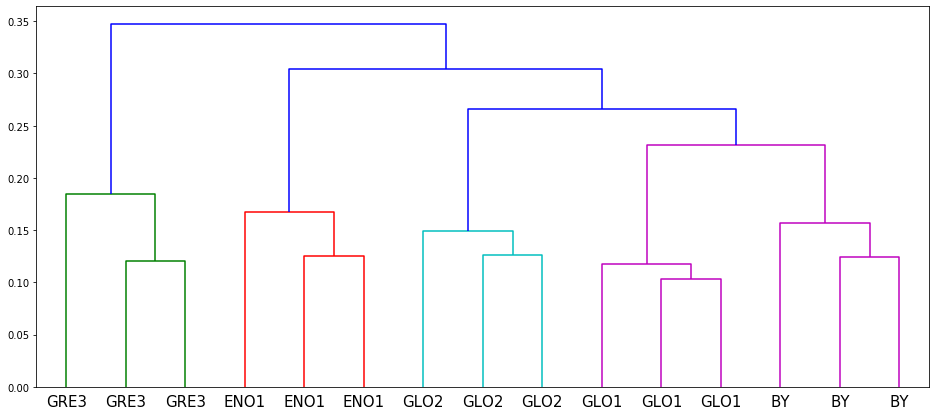

In [25]:
labels = ["BY","BY","BY","GRE3","GRE3","GRE3","ENO1","ENO1","ENO1","GLO1","GLO1","GLO1","GLO2","GLO2","GLO2"]
Zdice_neg = hier.linkage(NewD.T, metric = 'yule', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=labels,
                     leaf_font_size=15,
                     above_threshold_color='b')

In [26]:
VK = AlignedSpectra(NewD, labels = ["BY","BY","BY","GRE3","GRE3","GRE3","ENO1","ENO1","ENO1","GLO1","GLO1","GLO1","GLO2","GLO2","GLO2"])
VK.data

,BY0_000001,BY0_000002,BY0_000003,GRE3_000001,GRE3_000002,GRE3_000003,ENO1_000001,ENO1_000002,ENO1_000003,dGLO1_000001,dGLO1_000002,dGLO1_000003,GLO2_000001,GLO2_000002,GLO2_000003
"(0.2, 0.17142857142857143)",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"(0.2, 0.35)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0.2, 0.4)",1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
"(0.2, 0.55)",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"(0.20689655172413793, 0.034482758620689655)",0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3.0833333333333335, 0.2916666666666667)",0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3.0869565217391304, 0.17391304347826086)",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"(3.090909090909091, 0.09090909090909091)",0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3.090909090909091, 0.18181818181818182)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


### K-means clustering

In [27]:
import sklearn.cluster as skclust
import scaling as sca
import multianalysis as ma

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [28]:
Kmean = skclust.KMeans(n_clusters=5)

In [29]:
a = Kmean.fit(VK.data.T)

In [30]:
dicto = {}
for i in range(len(a.labels_)):
    if a.labels_[i] in dicto:
        dicto[a.labels_[i]].append(VK.labels[i])
    else:
        dicto[a.labels_[i]] = [VK.labels[i]]
dicto
discrim = ma.Kmeans_discrim(VK, method = 'average')
discrim

(0.8474449326557314,
 {'BY': 0.831447140728794,
  'GRE3': 0.8873507222895726,
  'ENO1': 0.8366600265340757,
  'GLO1': 0.831447140728794,
  'GLO2': 0.8503196329974214})

#### Random Forests

In [31]:
#Vector with values for the parameter n_estimators
values = {}
values['n_estimators'] = range(10,150,10)

In [32]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [33]:
param = []
test_score = []

clf.fit(VK.data.T, VK.labels)
param.append(clf.cv_results_['param_n_estimators'])
test_score.append(clf.cv_results_['mean_test_score'])

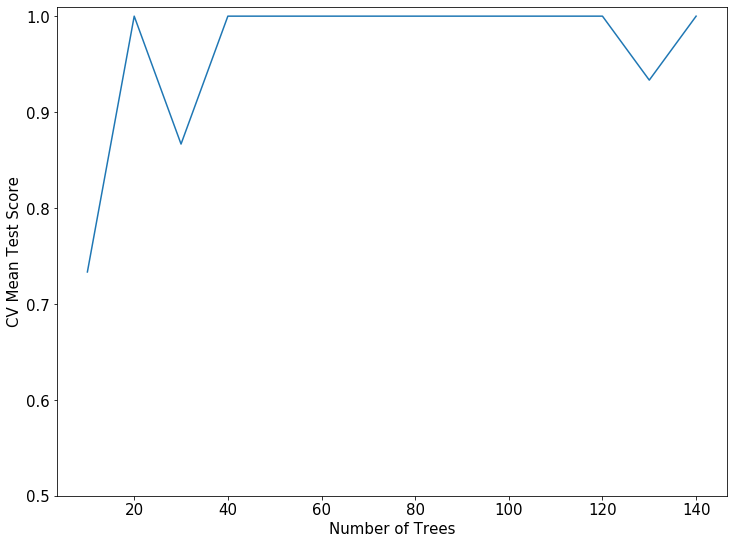

In [34]:
f, ax = plt.subplots(figsize=(12,9))
plt.plot(param[0], test_score[0])
plt.ylabel('CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
plt.ylim([0.5,1.01])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [35]:
P1_D = ma.simple_RF(VK, iter_num = 100)
Scores = P1_D[0]
Scores_std = np.std(P1_D[0])
Imp_feat = P1_D[1]

In [36]:
Imp_feat

[(642, 0.0033141374249773224, (1.6296296296296295, 0.0)),
 (998, 0.0032339799813760383, (2.0555555555555554, 0.05555555555555555)),
 (1326, 0.003201666413901664, (2.6666666666666665, 0.25)),
 (1283, 0.0031478738648392764, (2.5405405405405403, 0.13513513513513514)),
 (695, 0.0031312339909606414, (1.7142857142857142, 0.22857142857142856)),
 (1384, 0.0031090043394326476, (2.857142857142857, 0.07142857142857142)),
 (665, 0.0029629801163895977, (1.6666666666666667, 0.09523809523809523)),
 (1421, 0.0028494954734684867, (3.0, 0.3157894736842105)),
 (628, 0.0028191175144146835, (1.6153846153846154, 0.6923076923076923)),
 (1203, 0.0027876806964471073, (2.3333333333333335, 0.6666666666666666)),
 (984, 0.002740568255844642, (2.0416666666666665, 0.25)),
 (449, 0.002734028895271668, (1.25, 0.08333333333333333)),
 (524, 0.002728669947558071, (1.4166666666666667, 0.3333333333333333)),
 (735, 0.0027196675209879735, (1.7777777777777777, 0.2222222222222222)),
 (221, 0.002625435521404921, (0.705882352941

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive)

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A scatter plot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

In [37]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature and calculating
#% explained by these features (more)
ev = []
magni = []
more = []

Spectra = VK
ratio = []
nsamples = []
n_groups = []
number = round(0.02*len(Spectra))
magni.append(Imp_feat[0][1]/(1/len(Spectra)))
a = 0
for i in range(number): 
    a = a + Imp_feat[i][1]*100 
    ngroups = {}
    line = (Spectra.data.loc[[Imp_feat[i][2]],:] != 0)
    nsamples.append(int(line.sum(axis=1)))
    for n in range(len(line.columns)):
        if line.iloc[0,n] == True:
            ngroups[Spectra.labels[n]] = 1    
    n_groups.append(sum(list((ngroups.values()))))
    ratio.append(nsamples[-1]/n_groups[-1])
more.append(a)
df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
df['nsamples'] = nsamples
df['n_groups'] = n_groups
df['ratio']  = ratio
ev.append(df)
df

,nsamples,n_groups,ratio
0,3,1,3.0
1,3,1,3.0
2,3,1,3.0
3,3,1,3.0
4,3,1,3.0
5,3,1,3.0
6,3,1,3.0
7,3,1,3.0
8,3,1,3.0
9,3,1,3.0


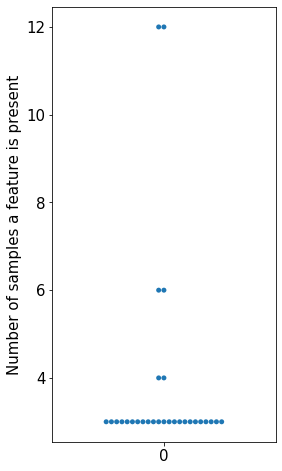

In [38]:
f, ax = plt.subplots(figsize=(4,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
sns.swarmplot(data=data, size = 5)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [39]:
print('Magnitude of most important feature:', magni)
print('% of model explained by the 2% most important features', more)

Magnitude of most important feature: [4.795556853942186]
% of model explained by the 2% most important features [7.968139879411905]


### Permutation Tests - Random Forests

Use of function permutation_RF in multianalysis.py

In [40]:
CV = {}
PMs = {}
pvalue = {}

In [41]:
permuta = ma.permutation_RF(VK, iter_num = 150, n_fold = 3)
CV['VK'] = permuta[0]
PMs['VK'] = permuta[1]
pvalue['VK'] = permuta[2]

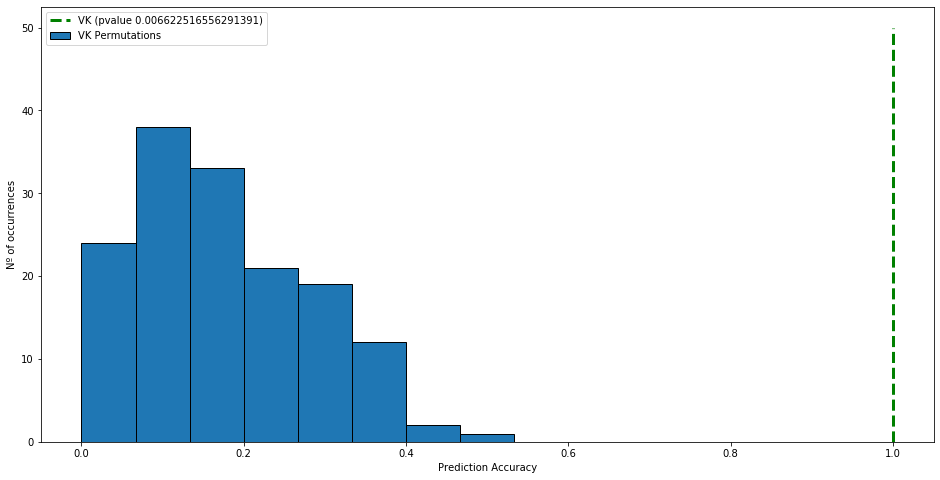

In [42]:
f, axes = plt.subplots(1, 1, figsize = (16,8))

Names = ['VK']
ylim = [0,50]
for i in range(len(Names)):
    plt.hist(PMs[Names[i]], len(VK.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black')#, alpha = 0.3)
    plt.plot(2 * [CV[Names[i]]], ylim, '--g', linewidth=3, #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue[Names[i]])
    plt.xlabel('Prediction Accuracy')
    plt.ylabel('Nº of occurrences')
    plt.legend()

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [43]:
matrix = pd.get_dummies(VK.labels)
matrix = matrix[["BY","GRE3","ENO1","GLO1","GLO2"]]

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 30 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function optim_PLS in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [44]:
%%capture
VK_PLS = ma.optim_PLS(VK, matrix, max_comp = 30)

Performance based on number of components


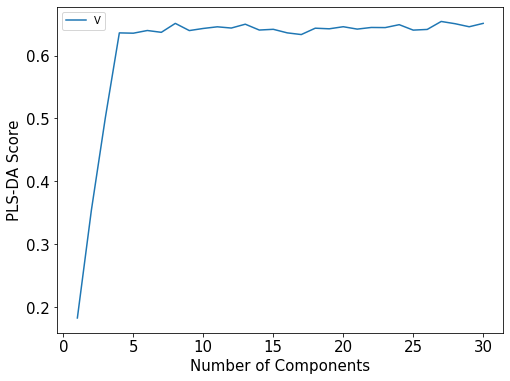

In [45]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31),VK_PLS[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(('VK'))
print('Performance based on number of components')

### Application of PLS-DA

The number of components seemed to be converged when it reached around 4/5 so 6 components were used from now on. Also MSE is the inverse of the score given by the PLS function of the module scikit-learn so from now on we will only collect the score knowing its meaning.

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [46]:
PLS_accu = {}
PLS_score = {}
PLS_Feat = {}

In [47]:
%%capture
VK_PLS = ma.model_PLSDA(VK, matrix, n_comp = 5, iter_num = 25, feat_type = 'VIP')
PLS_accu['VK'] = VK_PLS[0]
PLS_score['VK'] = VK_PLS[1]
PLS_Feat['VK'] = VK_PLS[3]

In [48]:
#VK.data.loc[[(1.3846153846153846, 0.38461538461538464)]]

In [50]:
PLS_accu['VK']

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

### Characteristics of the most important features

In [51]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []
for j in PLS_Feat:
    Spectra = VK
    index.append(j)
    ratio = []
    nsamples = []
    n_groups = []
    number = round(0.02*len(Spectra))
    total_m = 0
    for i in range(len(PLS_Feat[j])):
        total_m = total_m + PLS_Feat[j][i][1]
    magni.append(PLS_Feat[j][0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = (Spectra.data.loc[[PLS_Feat[j][i][2]],:] != 0)
        nsamples.append(int(line.sum(axis=1)))
        for n in range(len(line.columns)):
            if line.iloc[0,n] == True:
                ngroups[Spectra.labels[n]] = 1    
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [52]:
df

,nsamples,n_groups,ratio
0,6,2,3.000000
1,6,2,3.000000
2,6,2,3.000000
3,6,2,3.000000
4,6,2,3.000000
5,7,3,2.333333
6,7,3,2.333333
7,7,3,2.333333
8,6,2,3.000000
9,6,2,3.000000


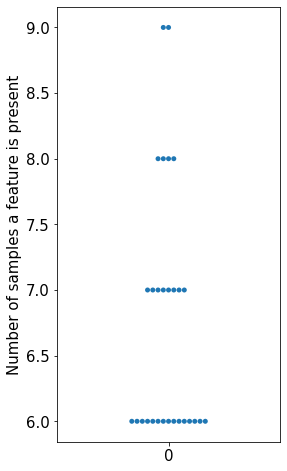

In [53]:
f, ax = plt.subplots(figsize=(4,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
sns.swarmplot(data=data, size = 5)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

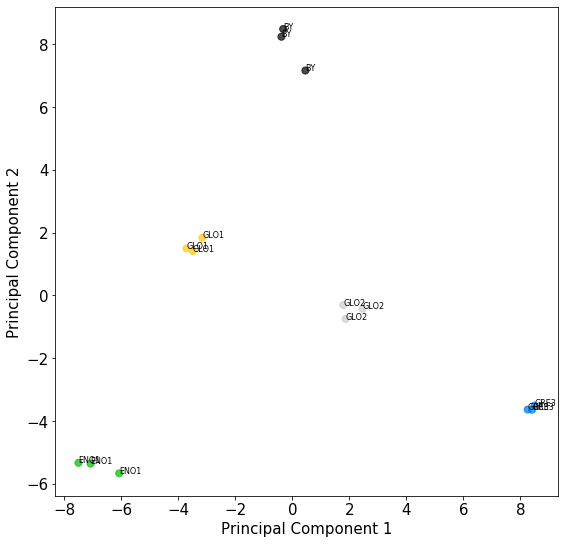

In [54]:
from sklearn.cross_decomposition import PLSRegression

plsda = PLSRegression(n_components = 6, scale = False)
#Fitting the model and getting the X_scores
plsda.fit(X=VK.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 5)
col_lbl = colours(range(5))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.unique_labels()[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

## Jaccard Distances Dendrogram Calculated Manually

In [116]:
jdists

,BY0_000001,BY0_000002,BY0_000003,GRE3_000001,GRE3_000002,GRE3_000003,ENO1_000001,ENO1_000002,ENO1_000003,dGLO1_000001,dGLO1_000002,dGLO1_000003,GLO2_000001,GLO2_000002,GLO2_000003
BY0_000001,0,0.459834,0.413893,0.569106,0.53794,0.549669,0.593931,0.568056,0.584239,0.52809,0.52095,0.520337,0.526241,0.547425,0.527624
BY0_000002,0.459834,0,0.419444,0.585052,0.582807,0.564394,0.61528,0.576923,0.590377,0.504801,0.524129,0.503411,0.548993,0.564433,0.530504
BY0_000003,0.413893,0.419444,0,0.585621,0.557441,0.549806,0.602797,0.563859,0.570281,0.514523,0.493056,0.481742,0.541096,0.543767,0.528302
GRE3_000001,0.569106,0.585052,0.585621,0,0.480742,0.471004,0.63,0.62938,0.652687,0.593197,0.599196,0.585598,0.55226,0.568336,0.560876
GRE3_000002,0.53794,0.582807,0.557441,0.480742,0,0.406926,0.630404,0.611482,0.622543,0.575472,0.572193,0.554348,0.550484,0.568212,0.551213
GRE3_000003,0.549669,0.564394,0.549806,0.471004,0.406926,0,0.627235,0.592,0.60705,0.55,0.546917,0.540541,0.540466,0.54702,0.52965
ENO1_000001,0.593931,0.61528,0.602797,0.63,0.630404,0.627235,0,0.478827,0.518809,0.582712,0.566319,0.576523,0.585586,0.617021,0.597685
ENO1_000002,0.568056,0.576923,0.563859,0.62938,0.611482,0.592,0.478827,0,0.435257,0.511799,0.504399,0.531792,0.556999,0.579092,0.557584
ENO1_000003,0.584239,0.590377,0.570281,0.652687,0.622543,0.60705,0.518809,0.435257,0,0.526012,0.537589,0.520173,0.584034,0.611702,0.570248
dGLO1_000001,0.52809,0.504801,0.514523,0.593197,0.575472,0.55,0.582712,0.511799,0.526012,0,0.428788,0.40832,0.510981,0.539638,0.525424


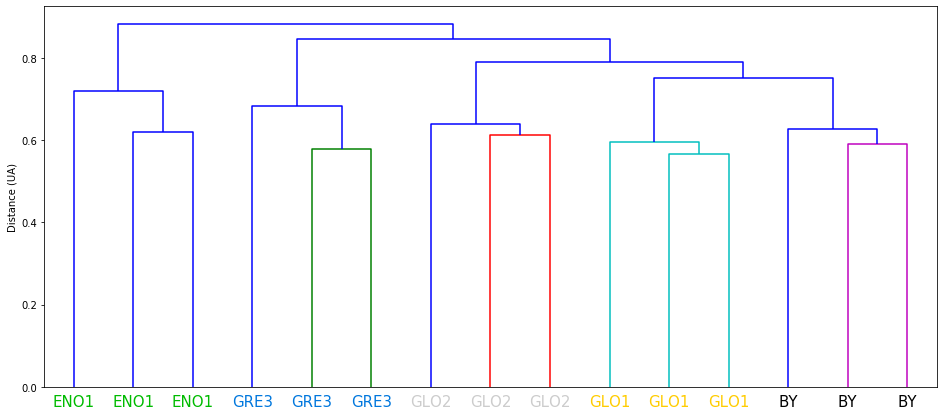

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hier
labels = ["BY","BY","BY","GRE3","GRE3","GRE3","ENO1","ENO1","ENO1","GLO1","GLO1","GLO1","GLO2","GLO2","GLO2"]
label_colors = {}
colours = cm.get_cmap('nipy_spectral', 5)
col_lbl = colours(range(5))
for i in range(len(col_lbl)):
    label_colors[labels[3*i]] = col_lbl[i]
    
    
Zdice_neg = hier.linkage(jdists, method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=labels,
                     leaf_font_size=15,
                     above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [226]:
jdists.columns = ["BY","BY","BY","GRE3","GRE3","GRE3","ENO1","ENO1","ENO1","GLO1","GLO1","GLO1","GLO2","GLO2","GLO2"]
jdists.index = ["BY","BY","BY","GRE3","GRE3","GRE3","ENO1","ENO1","ENO1","GLO1","GLO1","GLO1","GLO2","GLO2","GLO2"]
for i in range(15):
    for j in range(15):
        jdists.iloc[i,j] = np.float64(jdists.iloc[i,j])
        #print(type(jdists.iloc[i,j]))

In [225]:
#import seaborn as sns
#f, ax = plt.subplots(figsize=(12, 9))
#print(jdists.iloc[2:5,6:8])
#uniform_data = np.random.rand(10, 12)
#hm = sns.heatmap(jdists.to_numpy(), annot = True, ax=ax, cmap = sns.cm.rocket_r)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.show()

## Discrimination performance based on the number of compounds in each class

In [55]:
Classes_df = pd.DataFrame.from_dict(Classes)
Classes_df

,BY0_000001,BY0_000002,BY0_000003,GRE3_000001,GRE3_000002,GRE3_000003,ENO1_000001,ENO1_000002,ENO1_000003,dGLO1_000001,dGLO1_000002,dGLO1_000003,GLO2_000001,GLO2_000002,GLO2_000003
CHNS,11,19,16,16,18,11,13,19,20,14,15,11,11,15,12
CHO,80,90,89,83,91,99,69,82,82,98,98,98,84,87,85
CHON,124,123,123,115,116,128,88,103,94,111,110,112,99,97,93
CHONP,67,65,67,58,58,59,60,65,65,61,62,67,73,74,65
CHONS,143,148,131,110,117,125,110,123,131,120,124,120,116,143,141
CHONSP,57,63,60,62,65,57,54,51,55,50,57,48,52,54,63
CHOP,24,29,29,41,37,39,18,20,19,26,28,29,37,35,37
CHOS,37,42,50,39,52,51,21,33,37,33,34,36,33,35,37
other,19,24,28,23,23,23,21,20,23,22,18,23,22,29,29


#### Hierarchical Clustering Algorithm (Dendrograms)

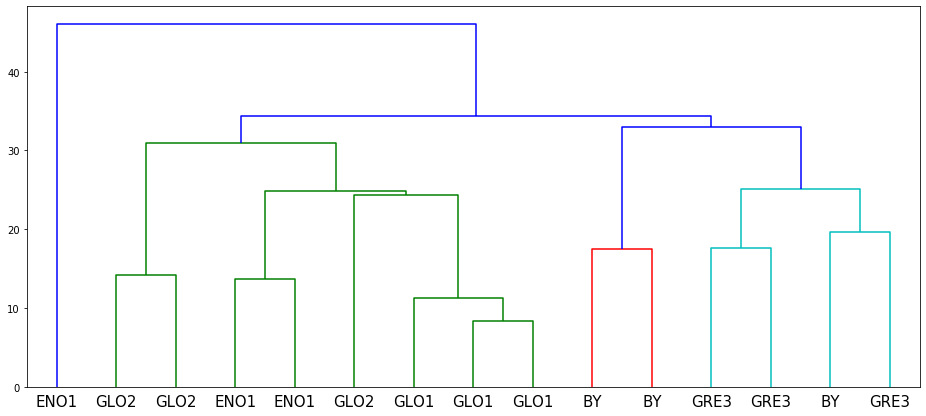

In [56]:
labels = ["BY","BY","BY","GRE3","GRE3","GRE3","ENO1","ENO1","ENO1","GLO1","GLO1","GLO1","GLO2","GLO2","GLO2"]
Zdice_neg = hier.linkage(Classes_df.T, metric = 'euclidean', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=labels,
                     leaf_font_size=15,
                     above_threshold_color='b')

In [57]:
CL = AlignedSpectra(Classes_df, labels = ["BY","BY","BY","GRE3","GRE3","GRE3","ENO1","ENO1","ENO1","GLO1","GLO1","GLO1","GLO2","GLO2","GLO2"])

### K-means clustering

#### Example of what happens in a K-means clustering and how samples are separated 

In [58]:
Kmean = skclust.KMeans(n_clusters=5)

In [59]:
a = Kmean.fit(CL.data.T)

In [60]:
dicto = {}
for i in range(len(a.labels_)):
    if a.labels_[i] in dicto:
        dicto[a.labels_[i]].append(CL.labels[i])
    else:
        dicto[a.labels_[i]] = [CL.labels[i]]
dicto
discrim = ma.Kmeans_discrim(CL, method = 'average')
discrim

(0.19023147418497902,
 {'BY': 0.5043036856149459,
  'GRE3': 0.4468536853099491,
  'ENO1': 0,
  'GLO1': 0,
  'GLO2': 0})

#### Random Forests

In [61]:
#Vector with values for the parameter n_estimators
values = {}
values['n_estimators'] = range(10,500,10)

In [62]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [63]:
param = []
test_score = []

clf.fit(CL.data.T, CL.labels)
param.append(clf.cv_results_['param_n_estimators'])
test_score.append(clf.cv_results_['mean_test_score'])

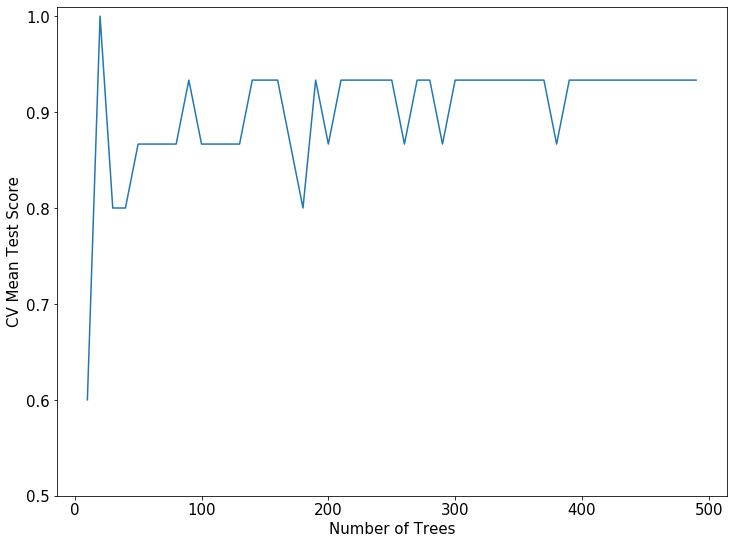

In [64]:
f, ax = plt.subplots(figsize=(12,9))
plt.plot(param[0], test_score[0])
plt.ylabel('CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
plt.ylim([0.5,1.01])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [66]:
P1_D = ma.simple_RF(CL, iter_num = 200)
Scores = P1_D[0]
Scores_std = np.std(P1_D[0])
Imp_feat = P1_D[1]

In [67]:
print(np.mean(Scores), ' +/- ', np.std(Scores))

0.8820000000000001  +/-  0.04975942121849885


Accuracy based on the dataset


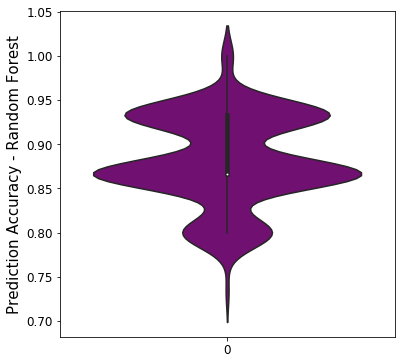

In [69]:
f, ax = plt.subplots(figsize=(6,6))
colors = ['purple','blue','green','red','purple','blue','orange','green','red']
data = pd.DataFrame.from_dict(Scores)
sns.violinplot( data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

In [70]:
Imp_feat

[(6, 0.15210479353515816, 'CHOP'),
 (2, 0.1504482644144201, 'CHON'),
 (1, 0.12985885655042612, 'CHO'),
 (3, 0.11912811325331649, 'CHONP'),
 (7, 0.10678042425628147, 'CHOS'),
 (4, 0.09633990844376625, 'CHONS'),
 (5, 0.09183132417544176, 'CHONSP'),
 (8, 0.08291790162096144, 'other'),
 (0, 0.07059041375022818, 'CHNS')]

### Permutation Tests - Random Forests

Use of function permutation_RF in multianalysis.py

In [71]:
CV = {}
PMs = {}
pvalue = {}

In [72]:
permuta = ma.permutation_RF(CL, iter_num = 150, n_fold = 3)
CV['CL'] = permuta[0]
PMs['CL'] = permuta[1]
pvalue['CL'] = permuta[2]

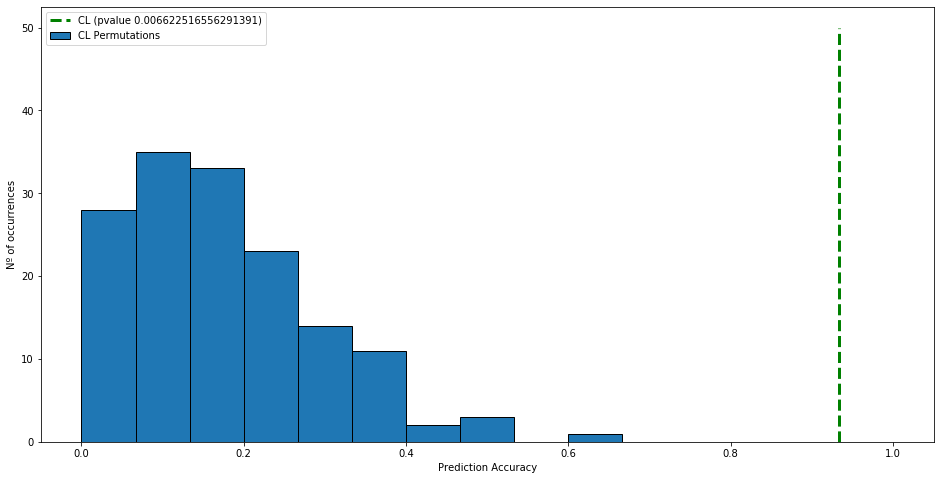

In [73]:
f, axes = plt.subplots(1, 1, figsize = (16,8))

Names = ['CL']
ylim = [0,50]
for i in range(len(Names)):
    plt.hist(PMs[Names[i]], len(VK.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black')#, alpha = 0.3)
    plt.plot(2 * [CV[Names[i]]], ylim, '--g', linewidth=3, #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue[Names[i]])
    plt.xlabel('Prediction Accuracy')
    plt.ylabel('Nº of occurrences')
    plt.legend()

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [74]:
matrix = pd.get_dummies(VK.labels)
matrix = matrix[["BY","GRE3","ENO1","GLO1","GLO2"]]

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 30 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function optim_PLS in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [75]:
%%capture
CL_PLS = ma.optim_PLS(CL, matrix, max_comp = 8)

Performance based on number of components


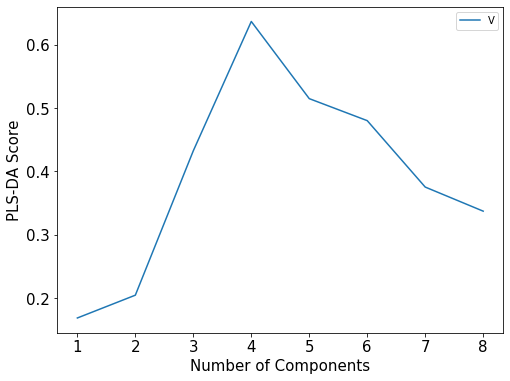

In [76]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,9),CL_PLS[0])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(('VK'))
print('Performance based on number of components')

### Application of PLS-DA

The number of components seemed to be converged when it reached around 4/5 so 6 components were used from now on. Also MSE is the inverse of the score given by the PLS function of the module scikit-learn so from now on we will only collect the score knowing its meaning.

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [77]:
PLS_accu = {}
PLS_score = {}
PLS_Feat = {}

In [82]:
%%capture
CL_PLS = ma.model_PLSDA(CL, matrix, n_comp = 4, iter_num = 200, feat_type = 'Weights')
PLS_accu['CL'] = CL_PLS[0]
PLS_score['CL'] = CL_PLS[1]
PLS_Feat['CL'] = CL_PLS[3]

In [79]:
PLS_Feat['CL']

[(2, 1.3608187480496596, 'CHON'),
 (4, 1.3128599006876833, 'CHONS'),
 (6, 1.3065597318818831, 'CHOP'),
 (1, 1.2846754374390503, 'CHO'),
 (7, 0.8372131050769155, 'CHOS'),
 (3, 0.6822901974318836, 'CHONP'),
 (5, 0.6697734661536876, 'CHONSP'),
 (0, 0.40719516025247926, 'CHNS'),
 (8, 0.4014423892238051, 'other')]

In [81]:
PLS_Feat['CL']

[(6, 0.09618687148999987, 'CHOP'),
 (1, 0.08735168935371113, 'CHO'),
 (2, 0.05921811155951488, 'CHON'),
 (4, 0.05892096379517912, 'CHONS'),
 (7, 0.04880276084398116, 'CHOS'),
 (5, 0.04255689113918239, 'CHONSP'),
 (3, 0.03884107275358789, 'CHONP'),
 (0, 0.03269389688785213, 'CHNS'),
 (8, 0.025753669573527104, 'other')]

In [83]:
PLS_Feat['CL']

[(1, 1.4852829627626487, 'CHO'),
 (6, 1.454754565663634, 'CHOP'),
 (2, 1.4314109966126882, 'CHON'),
 (4, 1.401610643087912, 'CHONS'),
 (7, 0.9658042623787693, 'CHOS'),
 (5, 0.7884619420122616, 'CHONSP'),
 (3, 0.7859422687768554, 'CHONP'),
 (8, 0.4322612186378442, 'other'),
 (0, 0.4251350993742481, 'CHNS')]

In [84]:
print(np.mean(PLS_accu['CL']), ' +/- ', np.std(PLS_accu['CL']))

0.9270000000000002  +/-  0.0571926568713152


Accuracy based on the dataset


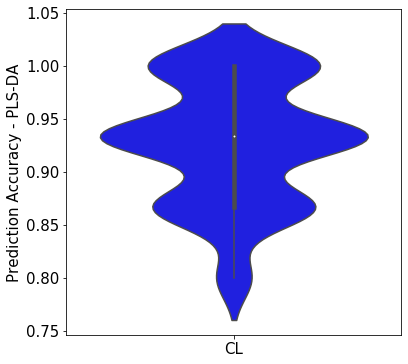

In [86]:
f, ax = plt.subplots(figsize=(6,6))
colors = ['blue']
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
print('Accuracy based on the dataset')

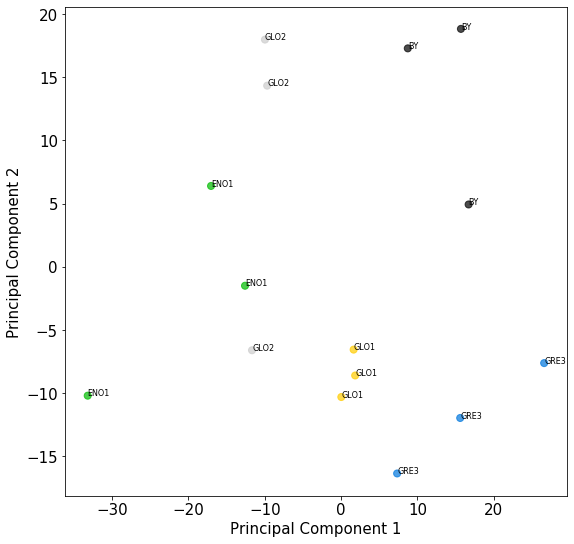

In [216]:
from sklearn.cross_decomposition import PLSRegression

plsda = PLSRegression(n_components = 4, scale = False)
#Fitting the model and getting the X_scores
plsda.fit(X=CL.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 5)
col_lbl = colours(range(5))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.unique_labels()[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [87]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [88]:
permuta = ma.permutation_PLSDA(CL, n_comp = 4, iter_num = 150)
CV_PLS['CL'] = permuta[0]
PMs_PLS['CL'] = permuta[1]
pvalue_PLS['CL'] = permuta[2]

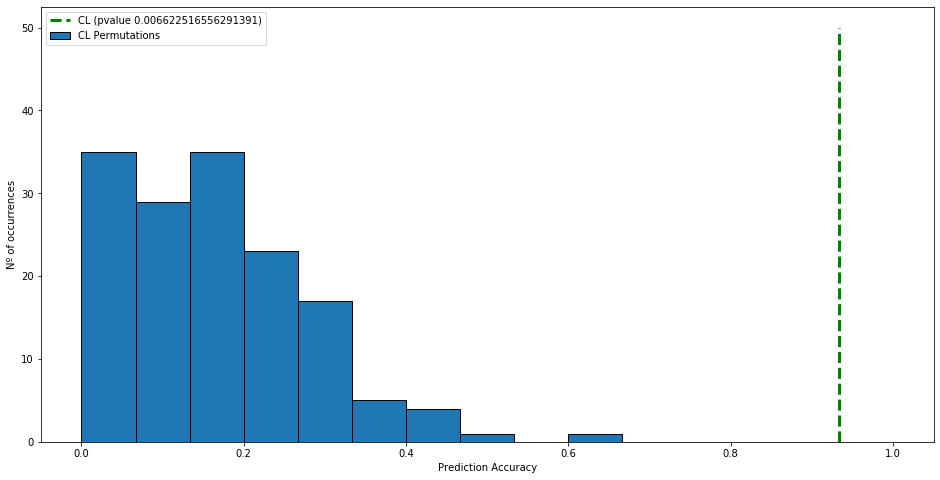

In [89]:
f, axes = plt.subplots(1, 1, figsize = (16,8))

Names = ['CL']
ylim = [0,50]
for i in range(len(Names)):
    plt.hist(PMs_PLS[Names[i]], len(CL.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black')#, alpha = 0.3)
    plt.plot(2 * [CV_PLS[Names[i]]], ylim, '--g', linewidth=3, #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue_PLS[Names[i]])
    plt.xlabel('Prediction Accuracy')
    plt.ylabel('Nº of occurrences')
    plt.legend()